In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import CalibrationDisplay

from ift6758.data import load_cached_seasons_dataframe, load_cached_season_dataframe

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import wandb

In [2]:
# on définit tous les variables explicativaes utilisées par les différents modèles qu'on va entrainer dans ce notebook 
feature_sets = {
    "Distance": ["shotDistance"],
    "Angle": ["shotAngle"],
    "Distance+Angle": ["shotDistance", "shotAngle"],
}

## Séparation des ensembles d'entraînement et de validation

In [3]:
df_training = load_cached_seasons_dataframe(2016,2019) 
df_test = load_cached_season_dataframe(2020) # on y touche pas jusqu'à la fin

In [4]:
SHOT_LIKE = {"shot-on-goal", "goal", "missed-shot"}

def add_attack_sign(df,
                    x_col="x", team_col="teamShot",
                    game_col="gameId", period_col="period",
                    event_col="typeEvent"):
    ndf = df.copy()

    shots = ndf[
        ndf[event_col].isin(SHOT_LIKE)
        & ndf[x_col].notna()
    ].copy()

    attack = (
        shots.groupby([game_col, period_col, team_col])[x_col]
        .median()
        .gt(0)
        .astype(int)
        .replace({0: -1, 1: 1})
        .rename("attack_sign")
        .reset_index()
    )

    ndf = ndf.merge(attack, on=[game_col, period_col, team_col], how="left")

    ndf["attack_sign"] = (
        ndf.groupby([game_col, team_col])["attack_sign"]
        .transform(lambda s: s.ffill().bfill())
    )

    return ndf

In [5]:
def new_variables(df, goal_x=89.0, goal_y=0.0,
                  x_col="x", y_col="y",
                  event_col="typeEvent", empty_col="openNet"):
    ndf = add_attack_sign(df, x_col=x_col, team_col="teamShot",
                          game_col="gameId", period_col="period", event_col=event_col)

    ndf["x_adj"] = ndf[x_col] * ndf["attack_sign"]
    ndf["y_adj"] = ndf[y_col] * ndf["attack_sign"]

    dx = goal_x - ndf["x_adj"]
    dy = ndf["y_adj"] - goal_y

    ndf["shotDistance"] = np.sqrt(dx**2 + dy**2)
    ndf["shotAngle"] = np.degrees(np.arctan2(dy.abs(), dx))
    ndf["isGoal"] = ndf[event_col].astype(str).str.lower().eq("goal")
    ndf["isEmpty"] = ndf[empty_col].fillna(False).astype(int).eq(1)

    return ndf

df = new_variables(df_training)

In [6]:
all_features = sorted({col for cols in feature_sets.values() for col in cols})

X_all = df[all_features].copy()
y = df["isGoal"].astype(int)

mask = X_all.notna().all(axis=1)
X_all = X_all.loc[mask]
y = y.loc[mask]

X_train, X_val, y_train, y_val = train_test_split(X_all, y, test_size=0.2, random_state=42)

# Régression Logistique sur la distance uniquement

In [7]:
X_train_dist = X_train[feature_sets["Distance"]]
X_val_dist   = X_val[feature_sets["Distance"]]

## Entrainement du modèle

In [8]:
clf_dist = LogisticRegression()
clf_dist.fit(X_train_dist, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

## Précision et matrice de confusion

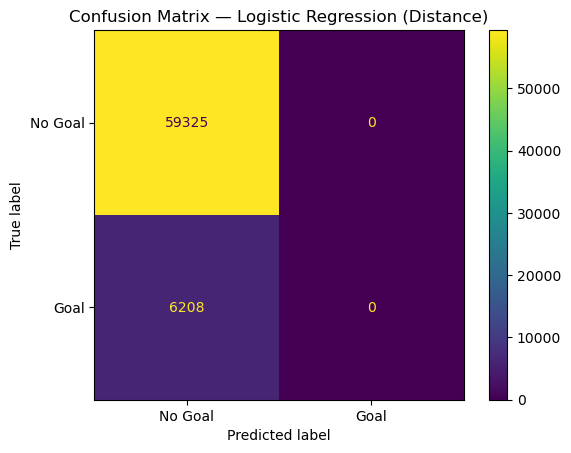

In [9]:
y_pred_dist = clf_dist.predict(X_val_dist)

acc_dist = accuracy_score(y_val, y_pred_dist)

disp = ConfusionMatrixDisplay.from_predictions(
    y_val, y_pred_dist,
    display_labels=["No Goal", "Goal"],   
    values_format="d"                   
)
plt.title("Confusion Matrix — Logistic Regression (Distance)")
plt.grid(False)
plt.show()

# Régression Logistique sur l'angle uniquement

In [10]:
X_train_angle = X_train[feature_sets["Angle"]]
X_val_angle   = X_val[feature_sets["Angle"]]

## Entrainement du modèle

In [11]:
clf_angle = LogisticRegression()
clf_angle.fit(X_train_angle, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

## Précision et matrice de confusion

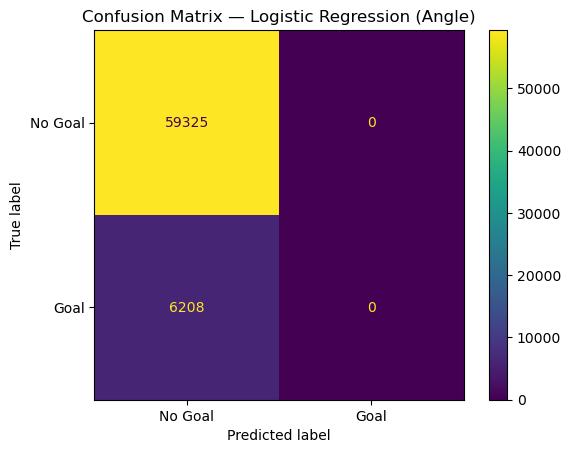

In [12]:
y_pred_angle = clf_angle.predict(X_val_angle)

acc_angle = accuracy_score(y_val, y_pred_angle)

disp = ConfusionMatrixDisplay.from_predictions(
    y_val, y_pred_angle,
    display_labels=["No Goal", "Goal"],   
    values_format="d"                   
)
plt.title("Confusion Matrix — Logistic Regression (Angle)")
plt.grid(False)
plt.show()

# Régression Logistique sur la distance + l'angle

In [13]:
X_train_both = X_train[feature_sets["Distance+Angle"]]
X_val_both   = X_val[feature_sets["Distance+Angle"]]

## Entrainement du modèle

In [14]:
clf_both = LogisticRegression()
clf_both.fit(X_train_both, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

## Précision et matrice de confusion 

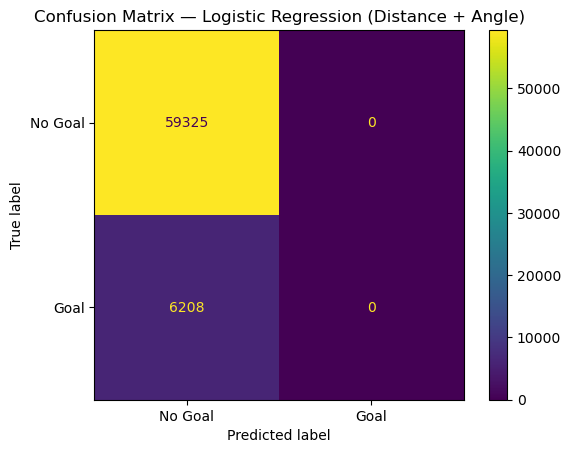

In [15]:
y_pred_both = clf_both.predict(X_val_both)

acc_both = accuracy_score(y_val, y_pred_both)

disp = ConfusionMatrixDisplay.from_predictions(
    y_val, y_pred_both,
    display_labels=["No Goal", "Goal"],   
    values_format="d"                   
)
plt.title("Confusion Matrix — Logistic Regression (Distance + Angle)")
plt.grid(False)
plt.show()

In [16]:
# On s'assure juste que c'est normal que les matrices de confusions sont toutes les mêmes, si les max sont < 0.5 
# le modèle prédira toujours que ce n'est pas un but.

pos_idx = 1  

proba_dist  = clf_dist.predict_proba(X_val_dist)[:, pos_idx]
proba_angle = clf_angle.predict_proba(X_val_angle)[:, pos_idx]
proba_both  = clf_both.predict_proba(X_val_both)[:, pos_idx]

print("max proba dist :", proba_dist.max())
print("max proba angle:", proba_angle.max())
print("max proba both :", proba_both.max())

max proba dist : 0.2184575732861414
max proba angle: 0.12368753304800015
max proba both : 0.30706833935720584


# Courbes ROC-AUC 

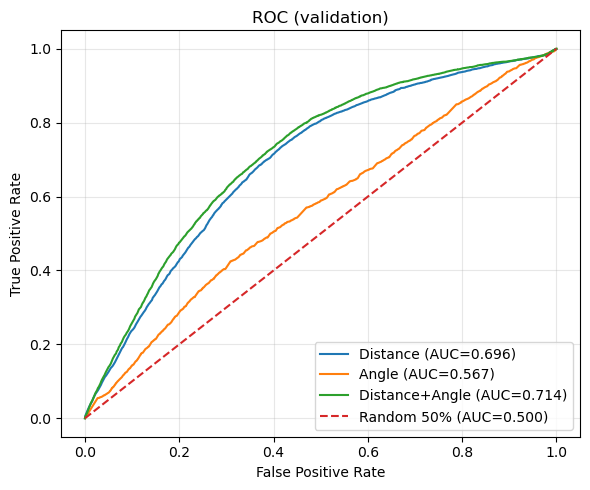

In [17]:
# Proba
pos_idx_dist  = np.where(clf_dist.classes_  == 1)[0][0]
pos_idx_angle = np.where(clf_angle.classes_ == 1)[0][0]
pos_idx_both  = np.where(clf_both.classes_  == 1)[0][0]

proba_dist  = clf_dist.predict_proba(X_val_dist)[:,  pos_idx_dist]
proba_angle = clf_angle.predict_proba(X_val_angle)[:, pos_idx_angle]
proba_both  = clf_both.predict_proba(X_val_both)[:,  pos_idx_both]

# ROC-AUC
fpr_dist,  tpr_dist,  _ = roc_curve(y_val, proba_dist)
auc_dist = roc_auc_score(y_val, proba_dist)

fpr_angle, tpr_angle, _ = roc_curve(y_val, proba_angle)
auc_angle = roc_auc_score(y_val, proba_angle)

fpr_both,  tpr_both,  _ = roc_curve(y_val, proba_both)
auc_both = roc_auc_score(y_val, proba_both)


plt.figure(figsize=(6,5))

plt.plot(fpr_dist,  tpr_dist,  label=f"Distance (AUC={auc_dist:.3f})")
plt.plot(fpr_angle, tpr_angle, label=f"Angle (AUC={auc_angle:.3f})")
plt.plot(fpr_both,  tpr_both,  label=f"Distance+Angle (AUC={auc_both:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", label="Random 50% (AUC=0.500)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (validation)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

#  Le taux de buts en fonction du centile de la probabilité de tir donnée par le modèle

In [18]:
def goal_rate_by_percentile(y_true, proba_goal, step=5):
    validation_df = pd.DataFrame({
        "is_goal": np.asarray(y_true).astype(int),
        "proba_goal": np.asarray(proba_goal),
    })

    validation_df["percentile"] = validation_df["proba_goal"].rank(pct=True) * 100.0

    percentile_bins = np.arange(0, 100 + step, step)
    validation_df["percentile_bin"] = pd.cut(
        validation_df["percentile"],
        bins=percentile_bins,
        include_lowest=True,
        right=False
    )

    goal_rate_table = (
        validation_df
        .groupby("percentile_bin", observed=True)["is_goal"]
        .mean()
        .reset_index(name="goal_rate")
    )

    bin_midpoints = np.array([
        interval.left + step / 2
        for interval in goal_rate_table["percentile_bin"]
    ])

    return bin_midpoints, goal_rate_table["goal_rate"].to_numpy()

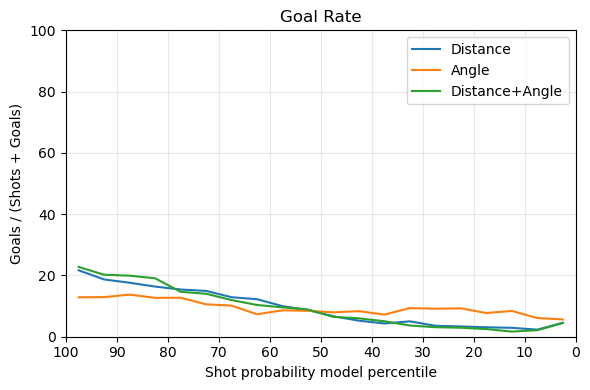

In [19]:
x_dist, goal_rate_dist = goal_rate_by_percentile(y_val, proba_dist, step=5)
goal_rate_dist_percent = 100.0 * goal_rate_dist

x_angle, goal_rate_angle = goal_rate_by_percentile(y_val, proba_angle, step=5)
goal_rate_angle_percent = 100.0 * goal_rate_angle

x_both, goal_rate_both = goal_rate_by_percentile(y_val, proba_both, step=5)
goal_rate_both_percent = 100.0 * goal_rate_both

plt.figure(figsize=(6, 4))

plt.plot(x_dist,  goal_rate_dist_percent,  label="Distance")
plt.plot(x_angle, goal_rate_angle_percent, label="Angle")
plt.plot(x_both,  goal_rate_both_percent,  label="Distance+Angle")

plt.title("Goal Rate")
plt.xlabel("Shot probability model percentile")
plt.ylabel("Goals / (Shots + Goals)")
plt.grid(alpha=0.3)

plt.xlim(100, 0)
plt.xticks(np.arange(0, 101, 10))
plt.ylim(0, 100)

plt.legend()
plt.tight_layout()
plt.show()

# Proportion cumulée de but en fonction du centile de la probabilité de tir donnée par le modèle

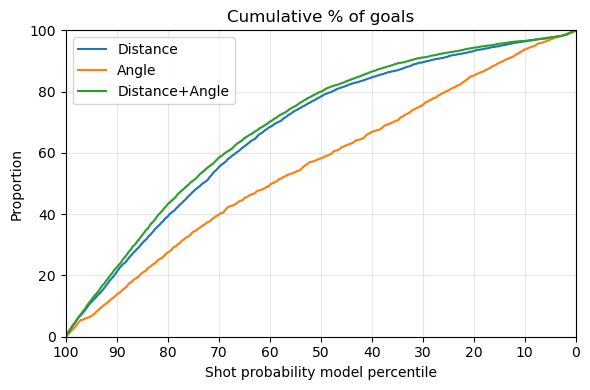

In [20]:
plt.figure(figsize=(6, 4))

# Model 1
order_dist = np.argsort(-proba_dist)
y_sorted_dist = np.asarray(y_val)[order_dist].astype(int)

total_goals_dist = y_sorted_dist.sum()
cum_goals_dist = np.cumsum(y_sorted_dist)

if total_goals_dist > 0:
    cum_prop_percent_dist = 100.0 * (cum_goals_dist / total_goals_dist)
else:
    cum_prop_percent_dist = np.zeros_like(cum_goals_dist, dtype=float)

pct_shots_selected_dist = (np.arange(1, len(y_sorted_dist) + 1) / len(y_sorted_dist)) * 100.0
shot_probability_percentile_dist = 100.0 - pct_shots_selected_dist

plt.plot(shot_probability_percentile_dist, cum_prop_percent_dist, label="Distance")

# Model 2
order_angle = np.argsort(-proba_angle)
y_sorted_angle = np.asarray(y_val)[order_angle].astype(int)

total_goals_angle = y_sorted_angle.sum()
cum_goals_angle = np.cumsum(y_sorted_angle)

if total_goals_angle > 0:
    cum_prop_percent_angle = 100.0 * (cum_goals_angle / total_goals_angle)
else:
    cum_prop_percent_angle = np.zeros_like(cum_goals_angle, dtype=float)

pct_shots_selected_angle = (np.arange(1, len(y_sorted_angle) + 1) / len(y_sorted_angle)) * 100.0
shot_probability_percentile_angle = 100.0 - pct_shots_selected_angle

plt.plot(shot_probability_percentile_angle, cum_prop_percent_angle, label="Angle")

# Model 3
order_both = np.argsort(-proba_both)
y_sorted_both = np.asarray(y_val)[order_both].astype(int)

total_goals_both = y_sorted_both.sum()
cum_goals_both = np.cumsum(y_sorted_both)

if total_goals_both > 0:
    cum_prop_percent_both = 100.0 * (cum_goals_both / total_goals_both)
else:
    cum_prop_percent_both = np.zeros_like(cum_goals_both, dtype=float)

pct_shots_selected_both = (np.arange(1, len(y_sorted_both) + 1) / len(y_sorted_both)) * 100.0
shot_probability_percentile_both = 100.0 - pct_shots_selected_both

plt.plot(shot_probability_percentile_both, cum_prop_percent_both, label="Distance+Angle")


plt.title("Cumulative % of goals")
plt.xlabel("Shot probability model percentile")
plt.ylabel("Proportion")
plt.grid(alpha=0.3)

plt.xlim(100, 0)
plt.xticks(np.arange(0, 101, 10))
plt.ylim(0, 100)

plt.legend()
plt.tight_layout()
plt.show()

# Diagramme de fiabilité

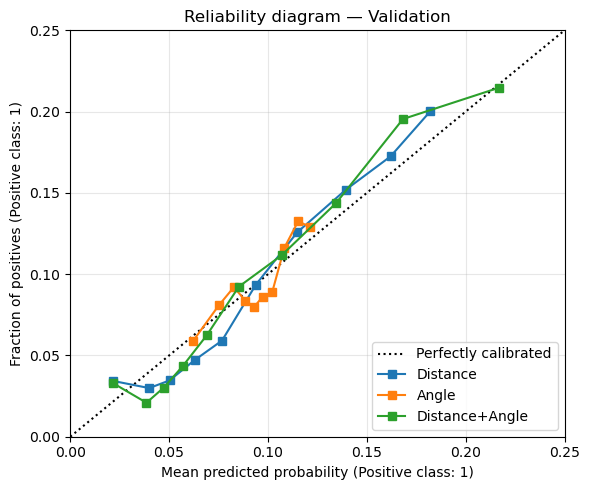

In [21]:
fig, ax = plt.subplots(figsize=(6, 5))

# Model 1
CalibrationDisplay.from_predictions(
    y_true=y_val,
    y_prob=proba_dist,
    n_bins=10,
    strategy="quantile",
    name="Distance",
    ax=ax
)

# Model 2
CalibrationDisplay.from_predictions(
    y_true=y_val,
    y_prob=proba_angle,
    n_bins=10,
    strategy="quantile",
    name="Angle",
    ax=ax
)

# Model 3
CalibrationDisplay.from_predictions(
    y_true=y_val,
    y_prob=proba_both,
    n_bins=10,
    strategy="quantile",
    name="Distance+Angle",
    ax=ax
)

ax.set_xlim(0, 0.25)
ax.set_ylim(0, 0.25)
ax.grid(alpha=0.3)
ax.set_title("Reliability diagram — Validation")
plt.tight_layout()
plt.show()

### Initialisation de Weights and Biaises

In [22]:
import os
import joblib

os.makedirs("models", exist_ok=True)

path_dist  = "models/lr_dist.joblib"
path_angle = "models/lr_angle.joblib"
path_both  = "models/lr_dist_angle.joblib"

joblib.dump(clf_dist, path_dist)
joblib.dump(clf_angle, path_angle)
joblib.dump(clf_both, path_both)

print("Saved:", path_dist, path_angle, path_both)

Saved: models/lr_dist.joblib models/lr_angle.joblib models/lr_dist_angle.joblib


In [31]:
with wandb.init(project="Projet Hockey Emerano", entity="stefan-sucatu-polytechnique-montr-al") as run:

    run.log_model(path= model_path, name="lr_dist")

with wandb.init(project="Projet Hockey Emerano", entity="stefan-sucatu-polytechnique-montr-al") as run:

    run.config.update({
        "model_type": "LogisticRegression(default)",
        "features_distance": ["shotDistance"],
        "features_angle": ["shotAngle"],
        "features_distance_angle": ["shotDistance", "shotAngle"],
        "split_seed": 42,
        "val_size": 0.2,
        "notes": "Baseline models for xG: Distance, Angle, Distance+Angle"
    })

    metrics_to_log = {}
    if "auc_dist" in globals():  metrics_to_log["val_auc_distance"] = auc_dist
    if "auc_angle" in globals(): metrics_to_log["val_auc_angle"] = auc_angle
    if "auc_both" in globals():  metrics_to_log["val_auc_distance_angle"] = auc_both

    if metrics_to_log:
        run.log(metrics_to_log)

    run.log_model(path=path_dist,  name="lr_distance")
    run.log_model(path=path_angle, name="lr_angle")
    run.log_model(path=path_both,  name="lr_distance_angle")

AttributeError: module 'wandb' has no attribute 'init'